# 5. Hypothesis Testing

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import mysql.connector
import datetime
import math
from scipy import stats
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler

In [8]:
username = 'username'
user_password = 'password'

In [9]:
cnx = mysql.connector.connect(
    user=username,
    password=user_password,
    host='localhost',
    database='final_transfer_market'
)

In [10]:
def position_type(df, dp):
    try:
        replace_dict = {
            'Central Midfield' : dp[2],
            'Right Winger' : dp[3],
            'Attacking Midfield' : dp[2],
            'Centre-Back' : dp[1],
            'Goalkeeper' : dp[0],
            'Centre-Forward' : dp[3],
            'Defensive Midfield' : dp[1],
            'Left-Back' : dp[1],
            'Right-Back' : dp[1],
            'Left Winger' : dp[3],
            'Second Striker' : dp[3],
            'Right Midfield' : dp[2],
            'Defender' : dp[1],
            'midfield' : dp[2],
            'Left Midfield' : dp[2],
            'Attack' : dp[3]
        }
        df ['position'] = df['position'].replace(replace_dict)
        return df
    except:
        return df

def PPI (df):
    df['PPI'] = 0
    df['played_ratio'] = df['minutes_played'] / (df['squad']*90)
    try:
        for index, row in df.iterrows():
            position = row['position']
            minutes_played = row['minutes_played']
            goals = row['goals']
            assists = row['assits']
            clean_sheets = row['clean_sheets']
            point_per_goal = row['point_per_goal']
            own_goals = row['own_goals']
            yellow_card = row['yellow_card']
            second_yellow_card = row['second_yellow_card']
            red_card = row['red_card']
            penalty_goals = row['penalty_goals']
            goals_conceded = row['goals_conceded']
            played_ratio = row['played_ratio']
            
            if position == 'Goalkeeper':
                df.at[index, 'PPI'] = max(clean_sheets*(0.4) + goals_conceded*(-0.3) + own_goals*(-0.4) + yellow_card*(-0.03) + second_yellow_card*(-0.05) + red_card*(-0.08) + played_ratio*(0.1) , 0)*100
            elif position == 'Defender':
                df.at[index, 'PPI'] = max(goals*(0.1) + penalty_goals*(0.05) + assists*(0.1) + clean_sheets*(0.2) + goals_conceded*(-0.2) + own_goals*(-0.4) + yellow_card*(-0.03) + second_yellow_card*(-0.05) + red_card*(-0.08) + played_ratio*(0.1) , 0)*100
            elif position == 'Midfielder':
                df.at[index, 'PPI'] = max(goals*(0.2) + penalty_goals*(0.05) + assists*(0.4) + own_goals*(-0.4) + yellow_card*(-0.03) + second_yellow_card*(-0.05) + red_card*(-0.08) + played_ratio*(0.1) , 0)*100
            elif position == 'Forward':
                df.at[index, 'PPI'] = max(goals*(0.4) + penalty_goals*(0.05) + assists*(0.2) + own_goals*(-0.4) + yellow_card*(-0.03) + second_yellow_card*(-0.05) + red_card*(-0.08) + played_ratio*(0.1) , 0)*100
            
            
            PPI_values = df['PPI'].values.reshape(-1, 1)
            scaler = MinMaxScaler()
            normalized_values = scaler.fit_transform(PPI_values)
            df['PPI'] = normalized_values
        return df
    except:
        return df

### 5.1. Players' Performance at the First Season in Each Team

In [11]:
q_h1 = "SELECT ps.* FROM transfers AS t LEFT JOIN players_season ps on t.player_id = ps.player_id AND t.season = ps.season LEFT JOIN players p on t.player_id = p.id WHERE t.season BETWEEN 2017 AND 2021;"
H1 = pd.read_sql(q_h1, con=cnx)
H1.head()

,id,player_id,season,club_id,squad,appearance,point_per_goal,goals,assits,own_goals,...,goals_conceded,clean_sheets,minutes_per_goal,minutes_played,competition,age,position,height,current_international,agent
0,42036.0,316884,2021.0,237.0,14.0,1.0,0.00,NaN,NaN,NaN,...,3.0,NaN,NaN,90.00,laliga,26.0,Goalkeeper,197.0,None,None
1,42037.0,316884,2021.0,237.0,1.0,1.0,3.00,NaN,NaN,NaN,...,NaN,1.0,NaN,120.00,copa-del-rey,26.0,Goalkeeper,197.0,None,None
2,243123.0,29051,2017.0,237.0,4.0,2.0,2.00,NaN,NaN,NaN,...,1.0,1.0,NaN,180.00,None,38.0,Goalkeeper,186.0,None,None
3,243124.0,29051,2017.0,237.0,36.0,35.0,1.83,NaN,NaN,NaN,...,27.0,16.0,NaN,3.15,segunda-division-b-grupo-iii-bis-20-21-,38.0,Goalkeeper,186.0,None,None
4,243125.0,29051,2017.0,237.0,1.0,0.0,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,copa-del-rey,38.0,Goalkeeper,186.0,None,None


In [12]:
positions_type = H1['position'].unique()
positions_type

array(['Goalkeeper', 'Centre-Back', 'Left-Back', 'Central Midfield',
       'Attacking Midfield', 'Left Winger', 'Right Winger',
       'Centre-Forward', 'Right-Back', 'Second Striker',
       'Defensive Midfield', 'Left Midfield', None, 'Right Midfield',
       'midfield', 'Attack'], dtype=object)

In [13]:
H1 = position_type(H1, positions_type)
H1.head()

,id,player_id,season,club_id,squad,appearance,point_per_goal,goals,assits,own_goals,...,goals_conceded,clean_sheets,minutes_per_goal,minutes_played,competition,age,position,height,current_international,agent
0,42036.0,316884,2021.0,237.0,14.0,1.0,0.00,NaN,NaN,NaN,...,3.0,NaN,NaN,90.00,laliga,26.0,Goalkeeper,197.0,None,None
1,42037.0,316884,2021.0,237.0,1.0,1.0,3.00,NaN,NaN,NaN,...,NaN,1.0,NaN,120.00,copa-del-rey,26.0,Goalkeeper,197.0,None,None
2,243123.0,29051,2017.0,237.0,4.0,2.0,2.00,NaN,NaN,NaN,...,1.0,1.0,NaN,180.00,None,38.0,Goalkeeper,186.0,None,None
3,243124.0,29051,2017.0,237.0,36.0,35.0,1.83,NaN,NaN,NaN,...,27.0,16.0,NaN,3.15,segunda-division-b-grupo-iii-bis-20-21-,38.0,Goalkeeper,186.0,None,None
4,243125.0,29051,2017.0,237.0,1.0,0.0,0.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,copa-del-rey,38.0,Goalkeeper,186.0,None,None


In [14]:
H1.iloc[:, 6:18] = H1.iloc[:, 6:18].fillna(0)
H1.head()

,id,player_id,season,club_id,squad,appearance,point_per_goal,goals,assits,own_goals,...,goals_conceded,clean_sheets,minutes_per_goal,minutes_played,competition,age,position,height,current_international,agent
0,42036.0,316884,2021.0,237.0,14.0,1.0,0.00,0.0,0.0,0.0,...,3.0,0.0,0.0,90.00,laliga,26.0,Goalkeeper,197.0,None,None
1,42037.0,316884,2021.0,237.0,1.0,1.0,3.00,0.0,0.0,0.0,...,0.0,1.0,0.0,120.00,copa-del-rey,26.0,Goalkeeper,197.0,None,None
2,243123.0,29051,2017.0,237.0,4.0,2.0,2.00,0.0,0.0,0.0,...,1.0,1.0,0.0,180.00,None,38.0,Goalkeeper,186.0,None,None
3,243124.0,29051,2017.0,237.0,36.0,35.0,1.83,0.0,0.0,0.0,...,27.0,16.0,0.0,3.15,segunda-division-b-grupo-iii-bis-20-21-,38.0,Goalkeeper,186.0,None,None
4,243125.0,29051,2017.0,237.0,1.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,copa-del-rey,38.0,Goalkeeper,186.0,None,None


In [15]:
H1 = PPI(H1)
H1.head()

,id,player_id,season,club_id,squad,appearance,point_per_goal,goals,assits,own_goals,...,minutes_per_goal,minutes_played,competition,age,position,height,current_international,agent,PPI,played_ratio
0,42036.0,316884,2021.0,237.0,14.0,1.0,0.00,0.0,0.0,0.0,...,0.0,90.00,laliga,26.0,Goalkeeper,197.0,None,None,0.0,0.071429
1,42037.0,316884,2021.0,237.0,1.0,1.0,3.00,0.0,0.0,0.0,...,0.0,120.00,copa-del-rey,26.0,Goalkeeper,197.0,None,None,0.0,1.333333
2,243123.0,29051,2017.0,237.0,4.0,2.0,2.00,0.0,0.0,0.0,...,0.0,180.00,None,38.0,Goalkeeper,186.0,None,None,0.0,0.500000
3,243124.0,29051,2017.0,237.0,36.0,35.0,1.83,0.0,0.0,0.0,...,0.0,3.15,segunda-division-b-grupo-iii-bis-20-21-,38.0,Goalkeeper,186.0,None,None,0.0,0.000972
4,243125.0,29051,2017.0,237.0,1.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.00,copa-del-rey,38.0,Goalkeeper,186.0,None,None,0.0,0.000000


In [16]:
current_year = datetime.date.today().year
H1['Historical_Age'] = H1['age'] - H1['season'].apply(lambda x: current_year - x)
H1_young = H1[H1['Historical_Age'] <= 30]
H1_old = H1[H1['Historical_Age'] > 30]

In [17]:
ppi_younger = H1_young['PPI'].values
ppi_older = H1_old['PPI'].values

t_statistic, p_value = stats.ttest_ind(ppi_younger, ppi_older)

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is evidence that players older than 30 have better performance than players younger than 30.")
else:
    print("Fail to reject the null hypothesis. There is no significant evidence to conclude that players older than 30 have better performance than players younger than 30.")

Fail to reject the null hypothesis. There is no significant evidence to conclude that players older than 30 have better performance than players younger than 30.


### 5.2. Champions League's Effect

This part is available on Descriptive statistics Final file.

### 5.3. Active Players vs Age

In [19]:
q_H3 = "SELECT c.name, c.average_age as players_avg_age, count((ps.appearance/ps.squad)>=0.2) AS active_players FROM players_season AS ps LEFT JOIN competitions c2 on ps.competition = c2.id LEFT JOIN clubs c on ps.club_id = c.id WHERE ps.season = 2021 AND c2.name IN ('Premier League', 'LaLiga', 'Bundesliga', 'Serie A', 'Ligue 1') GROUP BY ps.club_id;"

H3 = pd.read_sql(q_H3, con=cnx)
H3.head()

,name,players_avg_age,active_players
0,AS Monaco,24.0,29
1,Cagliari Calcio,25.9,39
2,Everton FC,25.7,39
3,Brentford FC,24.3,34
4,US Sassuolo,23.8,34


In [20]:
min_age = H3['players_avg_age'].min()
max_age = H3['players_avg_age'].max()

num_batches = int((max_age - min_age) / 2) + 1
batch_range = np.arange(min_age, max_age + 2, 2)
batch_range[1]

24.4

In [21]:
batch1 = H3[H3['players_avg_age'] < batch_range[1]]
batch2 = H3[(H3['players_avg_age'] >= batch_range[1]) & (H3['players_avg_age'] < batch_range[2])]
batch3 = H3[H3['players_avg_age'] >= batch_range[2]]
batch1.head()

,name,players_avg_age,active_players
0,AS Monaco,24.0,29
3,Brentford FC,24.3,34
4,US Sassuolo,23.8,34
10,RB Leipzig,24.1,26
13,ACF Fiorentina,22.9,35


In [22]:
f_statistic, p_value = f_oneway(batch1['active_players'], batch2['active_players'], batch3['active_players'])

print("ANOVA test results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)


ANOVA test results:
F-statistic: 0.36370499125065064
p-value: 0.6960598551312338


In [23]:
from scipy.stats import ttest_ind
t_statistic_1_2, p_value_1_2 = ttest_ind(batch1['active_players'], batch2['active_players'])
t_statistic_1_3, p_value_1_3 = ttest_ind(batch1['active_players'], batch3['active_players'])
t_statistic_2_3, p_value_2_3 = ttest_ind(batch2['active_players'], batch3['active_players'])

print("t-test results between Batch1 and Batch2:")
print("t-statistic:", t_statistic_1_2)
print("p-value:", p_value_1_2)
print()
print("t-test results between Batch1 and Batch3:")
print("t-statistic:", t_statistic_1_3)
print("p-value:", p_value_1_3)
print()
print("t-test results between Batch2 and Batch3:")
print("t-statistic:", t_statistic_2_3)
print("p-value:", p_value_2_3)


t-test results between Batch1 and Batch2:
t-statistic: 0.49737481213154916
p-value: 0.6203062928677434

t-test results between Batch1 and Batch3:
t-statistic: 0.9479415722418619
p-value: 0.3483366982920041

t-test results between Batch2 and Batch3:
t-statistic: 0.48438052751332783
p-value: 0.629695542290976


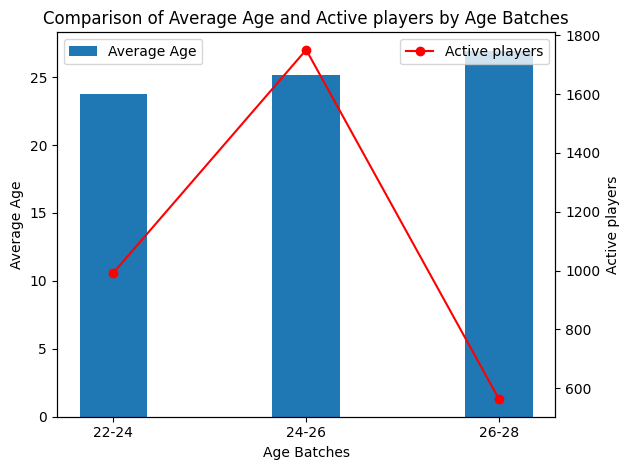

In [24]:
min_age = H3['players_avg_age'].min()
max_age = H3['players_avg_age'].max()

num_batches = int((max_age - min_age) / 2) + 1
batch_range = np.arange(min_age, max_age + 2, 2)

# Create empty lists to store the average ages and active players for each batch
avg_age_data = []
active_players_data = []

# Iterate through each batch and calculate the average age and active players
for i in range(num_batches):
    lower_bound = batch_range[i]
    upper_bound = batch_range[i+1]
    batch_data = H3[(H3['players_avg_age'] >= lower_bound) & (H3['players_avg_age'] < upper_bound)]
    
    avg_age = batch_data['players_avg_age'].mean()
    active_players = batch_data['active_players'].sum()
    
    avg_age_data.append(avg_age)
    active_players_data.append(active_players)


x = np.arange(num_batches)
width = 0.35

fig, ax1 = plt.subplots()

ax1.bar(x, avg_age_data, width, label='Average Age')
ax1.set_xlabel('Age Batches')
ax1.set_ylabel('Average Age')
ax1.set_xticks(x)
ax1.set_xticklabels([f'{int(batch_range[i])}-{int(batch_range[i+1])}' for i in range(num_batches)])
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(x, active_players_data, color='red', marker='o', label='Active players')
ax2.set_ylabel('Active players')
ax2.legend(loc='upper right')

plt.title('Comparison of Average Age and Active players by Age Batches')
plt.tight_layout()
plt.show()
